# XX网音乐推荐服务
## 项目背景
当前，很多网站提供在线播放音乐的功能。在线音乐可以令用户方便的收听自己感兴趣的曲目而无需进行下载。并且，网站也提供音乐播放列表的功能，用户可以将自己感兴趣的音乐存入播放列表中，方便下次进行收听。  
然而，用户播放音乐时，往往都是主动进行搜索的。网站的资源非常丰富，可能收藏很多用户感兴趣的曲目，但是受限于用户对曲目了解的广泛度，很多曲目用户未能发现，网站也因此错误了很多吸引用户的机会。  

## 项目实现
项目的目的在于，可以根据用户创建播放列表中的曲目（曲目名称以及艺人名称），去建立模型，进而可以根据现有的艺人与曲目信息，与网站现有的曲目进行匹配，自动推断出用户最可能感兴趣的曲目，从而达到吸引顾客，防止顾客流失，增加网站流量等目的。

## 扩展联想
该实现可以用于各种推荐的场景，而不限于音乐推荐。例如，小说，新闻，图书，广告推荐等。

## 数据集说明
数据集中含有4个特征，分别为：
* user_id 用户ID编号
* artistname 艺人名称
* trackname 曲目名称
* playlistname 播放列表名称

## 导入需要的库

In [1]:
import gensim
import pandas as pd
import math
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re
import random

## 数据加载与处理
如果直接读取数据集文件，会产生错误，其原因在于：
* 部分字段的文本信息中含有,分隔符，使用"将每个字段进行引用（"中的内容不会解析为分隔符）。  
* 但是，字段中的文本内容同样存在"，因此结构不当，造成解析错误。

In [2]:
# 出现错误，错误的原因在于文件当中出现了分隔符逗号(，)。
# 解决方案：
# 我们可以使用双引号对元素进行引用，通过引号引用的元素中，如果出现分隔符，将会当成普通的字符看待。
# 由此又会引发另外一个问题=》元素中依然存在双引号。
# 进一步解决方案：
# 元素中的双引号使用两个双引号进行转义。
file_name = "playlist.csv"
songs = pd.read_csv(file_name)

ParserError: Error tokenizing data. C error: Expected 4 fields in line 15931, saw 6


### 记录探索
通过观察数据情况，我们可以得知，解析错误的记录就是因为"的数量超过8个（字段文本中含有"），从而造成引用不当。
我们通过程序来计算可能造成解析错误的记录数量，进而决定采用何种方式进行处理。如果这样的数据较少，可考虑手动进行修改或是删除。

In [3]:
with open(file_name, encoding="utf-8") as f:
    c = 0
    for line in f:
        if line.count("\"") > 8:
            c += 1
print(c)

111231


### 原始数据处理
通过运行结果发现，可能造成解析错误的记录数量，为数不少。因此，手动处理这样的数据，并非是一种好的解决方案。  
我们采用程序的方式来进行处理。将字段中所有包含的非界定"替换为'。以免在解析时出现错误。

In [4]:
# 作为元素界定的引号存在这样的特征：
# 1 行首
# 2 行尾
# 3 引号前面是",
# 4 引号后面是,"
# 如果不符合以上4个特征中任意的一个者，则认为这样的引号就是元素中的内容，而不是元素的界定。我们
# 将作为元素中内容的双引号就可以替换为单引号（或其他字符）。
re_obj = re.compile(r'(?<!^)(?<!",)"(?!,")(?!$)')
new_file_name = "playlist2.csv"
with open(file_name, encoding="utf-8") as f, open(new_file_name, mode="wt", encoding="utf-8") as f2:
    for line in f:
        if line.count("\"") > 8:
            line = re_obj.sub("'", line)
        f2.write(line)

### 加载处理后的数据
经过如上对原始数据进行处理后，我们就可以加载新生成的数据集，并且不会产生解析错误。  
在加载之后，我们可以通过调用head，shape等输出数据集的一些简单信息。

In [5]:
songs = pd.read_csv(new_file_name)

In [6]:
display(songs.head())
display(songs.shape)

,user_id,"""artistname""","""trackname""","""playlistname"""
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010


(12902577, 4)

### 处理标题行
我们发现，原数据集中的标题列，分隔符的两端存在空格，如下：  
`"user_id", "artistname", "trackname", "playlistname"`  
这样会影响解析的结果（第一项元素没有引号，往后的元素存在引号）。我们在这里对标题行进行处理。

In [7]:
display(songs.columns)
songs.columns = songs.columns.map(lambda item: item.strip("\" "))
display(songs.columns)

Index(['user_id', ' "artistname"', ' "trackname"', ' "playlistname"'], dtype='object')

Index(['user_id', 'artistname', 'trackname', 'playlistname'], dtype='object')

## 数据清洗
对数据集进行探索，进而完成数据清洗的工作，包括：
* 缺失值处理
* 异常值处理
* 重复值处理

对于文本类型的数据，我们可能需要进行额外的清洗工作：
* 特殊字符以及标点符号的处理

### 缺失值处理
使用info方法或isnull方法查看缺失值信息。注意info方法在数据集数量不同时，默认的结果会存在一定的差异。

In [10]:
# 说明：当数据集较大时，为了计算速度，某些信息将不会显示，如果需要显示
# 相关信息，需要将对应的参数设置为True。
# songs.info()
# songs.info(null_counts=True)
songs.isnull().sum()

user_id             0
artistname      33568
trackname          85
playlistname       41
dtype: int64

通过结果我们发现，缺失值仅占据数据集总数很小的一部分（不足3‰），因此，可直接删除含有任意缺失值的记录。

In [11]:
songs.dropna(axis=0, how="any", inplace=True)
songs.isnull().sum()

user_id         0
artistname      0
trackname       0
playlistname    0
dtype: int64

### 异常值处理
对于文本类型的数据来说，通常异常值并不明显，不需要处理。

In [12]:
songs.describe()

,user_id,artistname,trackname,playlistname
count,12868940,12868940,12868940,12868940
unique,15914,289791,2010289,157350
top,4398de6902abde3351347b048fcdc287,Daft Punk,Intro,Starred
freq,295291,36086,6676,1334801


### 重复值处理
* 通过duplicated方法检查重复值信息。  
* 通过drop_duplicates删除重复值。

In [15]:
# songs.duplicated().sum()
# songs[songs.duplicated(keep=False)]
# songs.drop_duplicates(inplace=True)
display(songs.shape)

(12868912, 4)

## 数据转换与特征工程
### 曲目名称转换
在曲目这一列中，由于同一个曲目可能会因为年份，音质，演唱地点，重新录制等原因，出现各种版本，我们现在对曲目名称进行转换，对于同一个艺人，只要曲目名称相同，我们就认为是同一首曲目。  
我们首先来计算下，在曲目名称转换之前，不重复的曲目名称数量。

In [16]:
# nunique 返回去重之后记录的数量。
display(songs["trackname"].nunique())

2010289

然后再来输出下曲目名称的大致格式。这里，我们选择输出艺人pink floyd的部分曲目。

In [17]:
display(songs[songs["artistname"] == "pink floyd"].trackname[0:20])

8196001                    pink floyd - absolutely curtains
8196002    pink floyd - another brick in the wall, part two
8196003                    pink floyd - any colour you like
8196004                     pink floyd - apples and oranges
8196209                         pink floyd - biding my time
8196210          pink floyd - careful with that axe, eugene
Name: trackname, dtype: object

In [19]:
re_obj = re.compile(r"[\(\[].*?[\)\]]")

def preprocess_track(trackname):
    trackname = trackname.lower()
    # 在()或者[]中的内容，都是标记版本，年份，重新录制等内容，删除。
    trackname = re_obj.sub("", trackname)
    # 同理，-后面的内容也进行删除。
    trackname = trackname.split('-', 1)[0]
    trackname = trackname.strip()     
    return trackname

In [20]:
songs["trackname"] = songs["trackname"].apply(preprocess_track)
songs["artistname"] = songs["artistname"].map(lambda x: x.lower())

经过处理之后，我们再来输出处理之后的结果。

In [21]:
songs['trackname'].nunique()

1363747

In [22]:
display(songs[songs["artistname"] == "pink floyd"].trackname[0:20])

896                          sorrow
1057               comfortably numb
1058               comfortably numb
1098                         echoes
1099                        eclipse
1186                        hey you
1187                     high hopes
1414     shine on you crazy diamond
1554         welcome to the machine
1568             wish you were here
4193                   brain damage
5123                         echoes
5353                       fearless
7647                          money
10929            wish you were here
10930            wish you were here
11229                  brain damage
12235                         money
12809                         money
28819                one of the few
Name: trackname, dtype: object

### 受欢迎的艺人与曲目
我们现在来统计下最受欢迎的十大艺人与十大曲目。  
说明：
* 艺人名称通常不会相同。
* 曲目名称可能会相同。

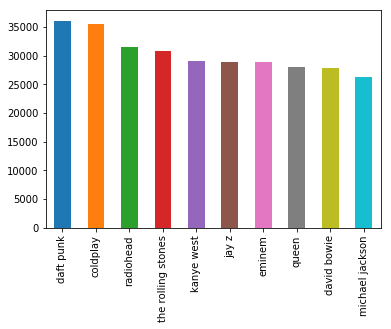

In [23]:
songs["artistname"].value_counts()[:10].plot(kind="bar")

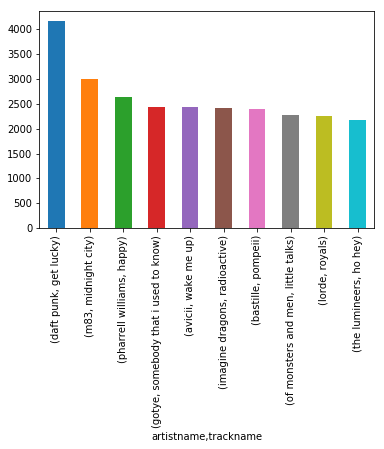

In [24]:
songs.groupby(["artistname", "trackname"]).size().sort_values(ascending=False)[:10].plot(kind="bar")

### 播放列表处理
我们对数据集进行进一步整理：
* 将用户与播放列表合并为一列。便于进行分组。
* 将艺人与曲目合并为一列，便于后续的建模。

In [ ]:
# 此种方法理论上是正确的，但是实际上运行会非常缓慢。
# def combine(x):
#     x["userplaylist"] = x["user_id"] + " - " + x["playlistname"]
#     x["trackartist"] = x["artistname"] + " - " + x["trackname"]
#     x.drop(["artistname", "trackname", "user_id", "playlistname"], inplace=True)
#     return x

# songs = songs.apply(combine, axis=1)

In [25]:
songs["userplaylist"] = songs["user_id"] + " - " + songs["playlistname"]
# 注意：增加两列内存消耗很大，当不需要时，最好立刻删除，释放有效的内存空间。
songs.drop(["user_id", "playlistname"], axis=1, inplace=True)
songs["trackartist"] = songs["artistname"] + " - " + songs["trackname"]
songs.drop(["artistname", "trackname"], axis=1, inplace=True)

In [26]:
songs.head()

,userplaylist,trackartist
0,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010,elvis costello - red shoes
1,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010,"elvis costello & the attractions - peace, love..."
2,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010,tiffany page - 7 years too late
3,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010,elvis costello & the attractions - accidents w...
4,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010,elvis costello - alison


为了稍后实现更好的数据建模，我们对播放列表进行处理，将列表长度小于10的分组进行删除。

In [30]:
def f(item):
    return len(item) > 2

df = pd.DataFrame([[1, 3], [2, 4], [1, 4], [2, 5], [1, 5]])
display(df)
g = df.groupby(0)
# filter方法用来进行过滤。该方法接收一个函数对象。函数对象具有一个参数。
# 当调用filter方法时，会将每个分组数据传递给方法的参数，如果方法的返回值为True，则
# 保留该组的数据，如果方法的返回值为False，则删除（过滤掉）该组的数据。
g.filter(f)

,0,1
0,1,3
1,2,4
2,1,4
3,2,5
4,1,5


,0,1
0,1,3
2,1,4
4,1,5


In [ ]:
g = songs.groupby("userplaylist")

songs = g.filter(lambda x: len(x) >= 10)

然后，我们对新的数据集重新根据用户与播放列表进行分组，并将每组的曲目与艺人组成一个列表。

In [31]:
g = songs.groupby("userplaylist")
songs = g["trackartist"].agg(lambda x: x.tolist())

In [32]:
songs.head()

userplaylist
00055176fea33f6e027cd3302289378b - favs                [jannik brunke - 18, green day - 21 guns, shaw...
0007f3dd09c91198371454c608d47f22 - 2014                [colourshop - 2014, tom odell - another love, ...
0007f3dd09c91198371454c608d47f22 - Fav songs           [bryan adams - i do it for you, colourshop - 2...
0007f3dd09c91198371454c608d47f22 - Sad songs            [johnny cash - hurt, brandi carlile - the story]
000b0f32b5739f052b9d40fcc5c41079 - Agnetha Fältskog    [hootenanny singers - dansen på sunnanö, agnet...
Name: trackartist, dtype: object

## 数据建模
### 训练模型

In [33]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [35]:
documents = songs.tolist()
# 当前词汇与预测词汇的最远距离。
window_size=7
# 训练迭代的轮数（epoch的数量）。
it=90
# 配置高频词汇进行随机下采样的阈值。
sample=0.001 
# 初始的学习率。
power_alpha=-0.5
# 词嵌入的维度。
size_embedding=50
# 如果大于0，将使用负采样。该值指定负采样时，选择噪声词的个数。
# 如果为0，则不使用负采样。
neg_sample=5
# 训练所使用的最大线程数。
workers=10
# 设置参与训练词汇的最低频率。
min_count=10
#sg 0 == cbow
#sg1 == skip gram
# sg_type=1

model = gensim.models.Word2Vec(documents[:1000], size=size_embedding, window=window_size,
                 min_count=min_count, workers=workers, sg=1, iter=it,
                 sample=sample, negative=neg_sample, alpha=power_alpha)

# 模型支持增量的方式继续训练。
# model.train(train,total_examples=len(train), epochs=model.iter)

2019-03-29 11:40:29,476 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-03-29 11:40:29,495 : INFO : collecting all words and their counts
2019-03-29 11:40:29,498 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-29 11:40:29,551 : INFO : collected 58385 word types from a corpus of 86008 raw words and 1000 sentences
2019-03-29 11:40:29,553 : INFO : Loading a fresh vocabulary
2019-03-29 11:40:29,627 : INFO : effective_min_count=10 retains 205 unique words (0% of original 58385, drops 58180)
2019-03-29 11:40:29,634 : INFO : effective_min_count=10 leaves 2733 word corpus (3% of original 86008, drops 83275)
2019-03-29 11:40:29,650 : INFO : deleting the raw counts dictionary of 58385 items
2019-03-29 11:40:29,654 : INFO : sample=0.001 downsamples 205 most-common words
2019-03-29 11:40:29,657 : INFO : downsampling leaves estimated 1786 word corpus (65.4% of prior 2733)
2019-03-29 11:40:29,661 : INFO : estimated required m

2019-03-29 11:40:30,154 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-29 11:40:30,156 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-29 11:40:30,158 : INFO : EPOCH - 7 : training on 86008 raw words (1806 effective words) took 0.0s, 57784 effective words/s
2019-03-29 11:40:30,202 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-29 11:40:30,209 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-29 11:40:30,212 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-29 11:40:30,216 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-29 11:40:30,217 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-29 11:40:30,218 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-29 11:40:30,219 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-29 11:40:30,220 : INFO : worker thread fin

2019-03-29 11:40:30,610 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-29 11:40:30,613 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-29 11:40:30,617 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-29 11:40:30,619 : INFO : EPOCH - 15 : training on 86008 raw words (1772 effective words) took 0.1s, 31254 effective words/s
2019-03-29 11:40:30,641 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-29 11:40:30,643 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-29 11:40:30,650 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-29 11:40:30,652 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-29 11:40:30,660 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-29 11:40:30,663 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-29 11:40:30,667 : INFO : worker thread fi

2019-03-29 11:40:31,088 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-29 11:40:31,090 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-29 11:40:31,092 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-29 11:40:31,100 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-29 11:40:31,104 : INFO : EPOCH - 23 : training on 86008 raw words (1802 effective words) took 0.0s, 38276 effective words/s
2019-03-29 11:40:31,137 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-29 11:40:31,144 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-29 11:40:31,147 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-29 11:40:31,149 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-29 11:40:31,151 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-29 11:40:31,153 : INFO : worker thread fi

2019-03-29 11:40:31,654 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-29 11:40:31,659 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-29 11:40:31,661 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-29 11:40:31,663 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-29 11:40:31,667 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-29 11:40:31,669 : INFO : EPOCH - 31 : training on 86008 raw words (1812 effective words) took 0.0s, 44374 effective words/s
2019-03-29 11:40:31,721 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-29 11:40:31,726 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-29 11:40:31,728 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-29 11:40:31,735 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-29 11:40:31,740 : INFO : worker thread fi

2019-03-29 11:40:32,136 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-29 11:40:32,139 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-29 11:40:32,143 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-29 11:40:32,144 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-29 11:40:32,145 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-29 11:40:32,146 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-29 11:40:32,147 : INFO : EPOCH - 39 : training on 86008 raw words (1783 effective words) took 0.0s, 46411 effective words/s
2019-03-29 11:40:32,167 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-29 11:40:32,170 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-29 11:40:32,172 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-29 11:40:32,178 : INFO : worker thread fi

2019-03-29 11:40:32,540 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-29 11:40:32,542 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-29 11:40:32,544 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-29 11:40:32,546 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-29 11:40:32,548 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-29 11:40:32,552 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-29 11:40:32,553 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-29 11:40:32,556 : INFO : EPOCH - 47 : training on 86008 raw words (1790 effective words) took 0.0s, 59150 effective words/s
2019-03-29 11:40:32,571 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-29 11:40:32,582 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-29 11:40:32,587 : INFO : worker thread fi

2019-03-29 11:40:32,967 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-29 11:40:32,975 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-29 11:40:32,979 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-29 11:40:32,982 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-29 11:40:33,002 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-29 11:40:33,005 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-29 11:40:33,006 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-29 11:40:33,007 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-29 11:40:33,008 : INFO : EPOCH - 55 : training on 86008 raw words (1770 effective words) took 0.1s, 34785 effective words/s
2019-03-29 11:40:33,020 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-29 11:40:33,025 : INFO : worker thread fi

2019-03-29 11:40:33,387 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-29 11:40:33,397 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-29 11:40:33,401 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-29 11:40:33,403 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-29 11:40:33,405 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-29 11:40:33,407 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-29 11:40:33,408 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-29 11:40:33,410 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-29 11:40:33,411 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-29 11:40:33,412 : INFO : EPOCH - 63 : training on 86008 raw words (1785 effective words) took 0.0s, 42797 effective words/s
2019-03-29 11:40:33,432 : INFO : worker thread fi

2019-03-29 11:40:33,813 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-29 11:40:33,815 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-29 11:40:33,824 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-29 11:40:33,828 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-29 11:40:33,832 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-29 11:40:33,838 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-29 11:40:33,839 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-29 11:40:33,840 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-29 11:40:33,841 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-29 11:40:33,843 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-29 11:40:33,844 : INFO : EPOCH - 71 : training on 86008 raw words (1850 effective 

2019-03-29 11:40:34,233 : INFO : EPOCH - 78 : training on 86008 raw words (1804 effective words) took 0.0s, 80991 effective words/s
2019-03-29 11:40:34,248 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-29 11:40:34,259 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-29 11:40:34,261 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-29 11:40:34,263 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-29 11:40:34,265 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-29 11:40:34,272 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-29 11:40:34,275 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-29 11:40:34,288 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-29 11:40:34,293 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-29 11:40:34,298 : INFO : worker thread fi

2019-03-29 11:40:34,660 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-29 11:40:34,662 : INFO : EPOCH - 86 : training on 86008 raw words (1778 effective words) took 0.0s, 48993 effective words/s
2019-03-29 11:40:34,692 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-29 11:40:34,707 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-29 11:40:34,713 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-29 11:40:34,716 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-29 11:40:34,721 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-29 11:40:34,723 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-29 11:40:34,724 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-29 11:40:34,726 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-29 11:40:34,728 : INFO : worker thread fi

### 使用模型进行预测

In [44]:
# model.wv.vocab
# model.wv.vectors
# model.wv.most_similar("ed sheeran - thinking out loud", topn=5)
# model.wv.most_similar(positive=["ed sheeran - thinking out loud"], negative=["talking heads - and she was"], topn=5)
# model.wv.similarity("ed sheeran - thinking out loud", "talking heads - and she was")

0.9999455

### 保存与载入模型

In [6]:
# model.save(path)
model = gensim.models.Word2Vec.load("word2vec.model")

100

## 词嵌入可视化

In [47]:
# 进行降维，参数指定降维的维数。
tsne = TSNE(n_components=2)
# 获取所有词汇标签。
y = list(model.wv.vocab.keys())
# 取部分词汇标签，进行可视化展示。
y = y[:30]
# 根据词获取嵌入向量。
X = model.wv[y]
# 进行降维转换。
X_tsne = tsne.fit_transform(X)

In [49]:
X_tsne.shape

(30, 2)

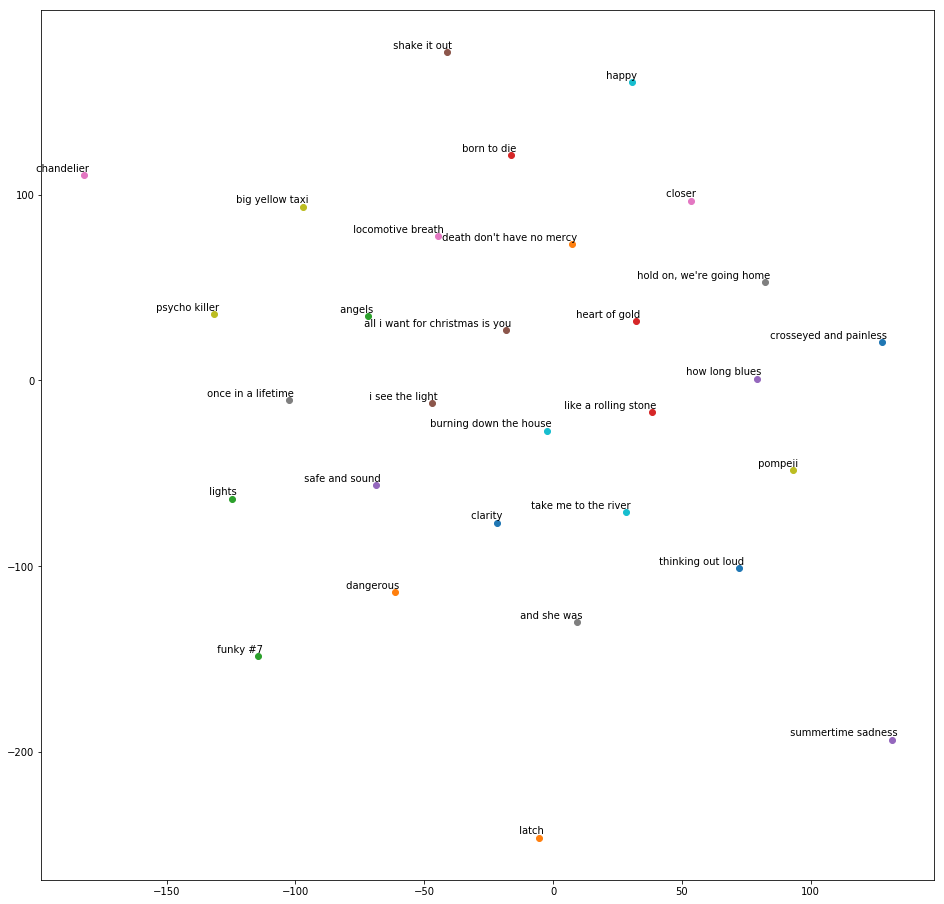

In [50]:
def label_format(label, condition=0):
    if condition == 1:
        return label.split("-", 1)[0]
    elif condition == 2:
        return label.split("-", 1)[1]
    else:
        return label


plt.figure(figsize=(16, 16)) 

for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i,0],X_tsne[i,1])
    # 在散点上打上标签（单词的文本）
    plt.annotate(label_format(y[i], 2),
                 xy=(X_tsne[i,0],X_tsne[i,1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()